In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
import warnings
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")
import yaml
import os
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
import os
import yaml
import pickle

pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', 300)
from sklearn.metrics import (precision_score,recall_score,
                             f1_score, accuracy_score,confusion_matrix, classification_report)

In [3]:
colorcode=pd.read_csv('../data/processed/color_code.csv',index_col=0)
train=pd.read_csv('../data/train/train.csv',index_col=0)
test=pd.read_csv('../data/test/test.csv',index_col=0)

In [4]:
X_train=train[['ABV','IBU','Color']]
X_test=test[['ABV','IBU','Color']]

y_train=train['Style_color']
y_test=test['Style_color']

In [5]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

Let's try the remaining classification models just to double-check.

In [6]:
pipe2 = Pipeline(steps=[
    ('classifier', LogisticRegression()), #dummy classifier to execute the pipeline
])


In [7]:
from sklearn.tree import DecisionTreeClassifier
svm_params = {
    'classifier': [SVC()],
    'classifier__C': [0.1,1,10],
    'classifier__kernel':['linear', 'poly', 'rbf',]
}

abc_params = {
    'classifier': [AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),)],
    'classifier__learning_rate':[0.01,0.1,0.5],
    'classifier__base_estimator__max_depth':[1,2,3],
     'classifier__base_estimator__criterion': ['entropy', 'gini']
}

search_space2 = [
    svm_params,
    abc_params 
]


In [8]:

scoring={'f1_weighted': 'f1_weighted'}
dtc_gs = GridSearchCV(estimator=pipe2, param_grid=search_space2, cv=5, scoring=scoring, refit='f1_weighted',verbose=3, n_jobs=-1,error_score='raise')

In [9]:
dtc_gs.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'classifier__kernel': ['linear', 'poly', 'rbf']},
                         {'classifier': [AdaBoostClassifier(base_estimator=DecisionTreeClassifier())],
                          'classifier__base_estimator__criterion': ['entropy',
                                                                    'gini'],
                          'classifier__base_estimator__max_depth': [1, 2, 3],
                          'classifier__learning_rate': [0.01, 0.1, 0.5]}],
             refit='f1_weighted', scoring={'f1_weighted': 'f1_weighted'},
             verbose=3)

In [10]:
print(dtc_gs.best_estimator_)
print(dtc_gs.best_score_)
print(dtc_gs.best_params_)

Pipeline(steps=[('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    learning_rate=0.01))])
0.8119393123301194
{'classifier': AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 'classifier__base_estimator__criterion': 'gini', 'classifier__base_estimator__max_depth': 3, 'classifier__learning_rate': 0.01}


In [11]:
# y_predScale = clf_gs.best_estimator_.predict(X_test)
y_pred2 = dtc_gs.best_estimator_.predict(X_test)

In [12]:

print('accuracy_score',accuracy_score(y_pred2,y_test))
print('precision_score',precision_score(y_pred2,y_test, average='weighted'))
print('f1_score',f1_score(y_pred2,y_test, average='weighted'))
print('recall_score',recall_score(y_pred2,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

accuracy_score 0.9044014578076816
precision_score 0.9020955344780237
f1_score 0.901824713368674
recall_score 0.9044014578076816


In [13]:
cm = confusion_matrix(y_test, y_pred2,normalize='true')

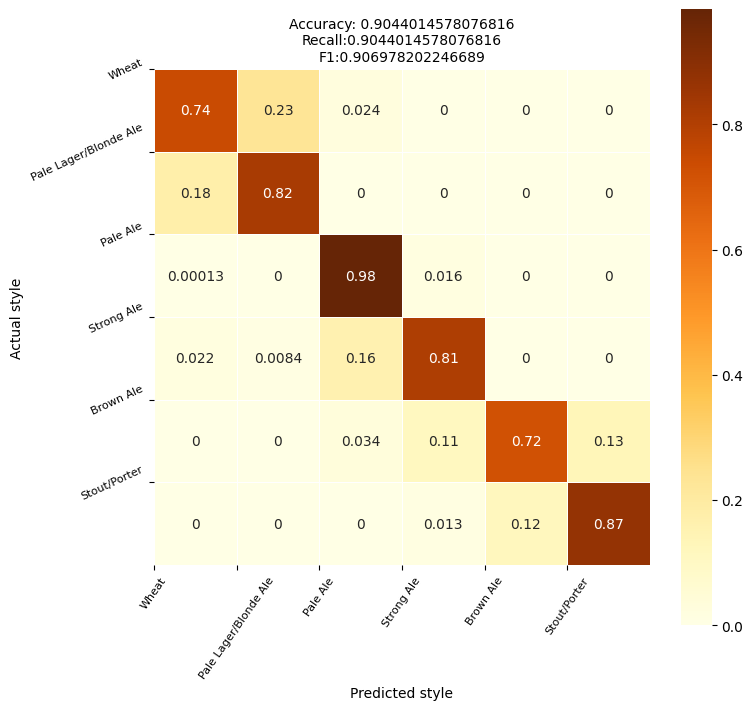

In [14]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_pred2)}\nRecall:{recall_score(y_test, y_pred2, average="weighted")}\nF1:{f1_score(y_test, y_pred2, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

In [15]:
current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'adaboost_config.yaml'), 'w') as file:
    yaml.dump(dtc_gs.best_params_, file, default_flow_style=False)

with open('../models/trained_model_adaboost_dtc.pkl', 'wb') as output:
    pickle.dump(dtc_gs.best_estimator_, output)

Although AdaBoost was quite effective, Gradient Boosting Classifier is still the best model so far.

### Now that we know what is the best estimator by far, let's work on its parameters.

In [16]:
gb_params = { #Gradient Boosting
    'learning_rate':[0.01,0.1],
    # 'n_estimators':[50,100,150],
    'criterion':['friedman_mse'],
    # 'min_samples_split':[2,3],
    'min_samples_leaf':[1,2],
    'max_depth':[2,3],
    # 'max_features':[None,2,3],
    # 'max_leaf_nodes':[None,2,3]
}

In [17]:
gbc_rs = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions=gb_params, cv=3, scoring='f1_weighted', verbose=2, n_jobs=8, random_state=42)

gbc_rs.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=8,
                   param_distributions={'criterion': ['friedman_mse'],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [2, 3],
                                        'min_samples_leaf': [1, 2]},
                   random_state=42, scoring='f1_weighted', verbose=2)

In [18]:
print(gbc_rs.best_estimator_)
print(gbc_rs.best_score_)
print(gbc_rs.best_params_)

GradientBoostingClassifier(min_samples_leaf=2)
0.8596647260146133
{'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1, 'criterion': 'friedman_mse'}


In [21]:
y_pred_rs = gbc_rs.best_estimator_.predict(X_test)
print('accuracy_score',accuracy_score(y_pred_rs,y_test))
print('precision_score',precision_score(y_pred_rs,y_test, average='weighted'))
print('f1_score',f1_score(y_pred_rs,y_test, average='weighted'))
print('recall_score',recall_score(y_pred_rs,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

accuracy_score 0.9044014578076816
precision_score 0.9017315983526684
f1_score 0.8995305455250483
recall_score 0.9044014578076816


In [19]:
with open('../models/trained_model_gbc_rs.pkl', 'wb') as output:
    pickle.dump(gbc_rs.best_estimator_, output)

current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'gbc_rs_config.yaml'), 'w') as file:
    yaml.dump(gbc_rs.best_params_, file, default_flow_style=False)

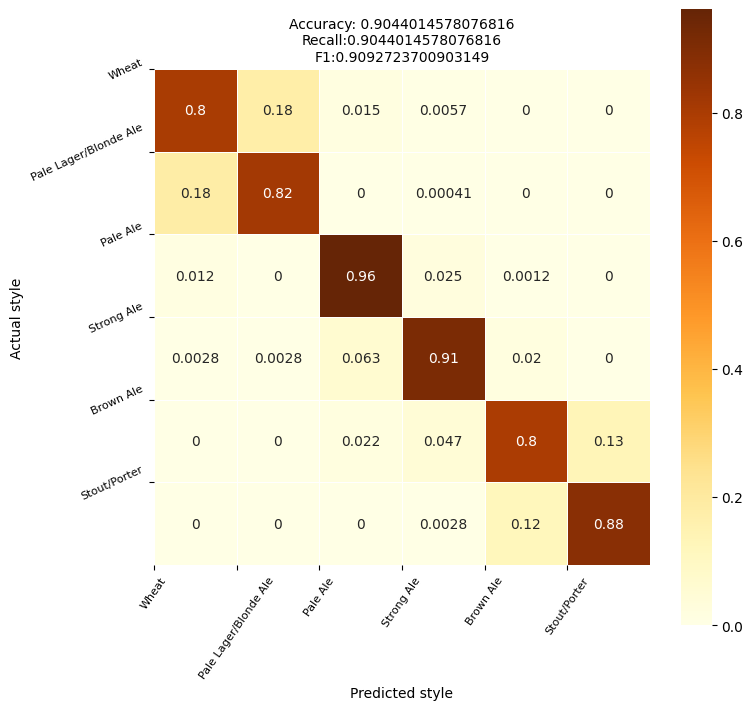

In [22]:
cm = confusion_matrix(y_test, y_pred_rs,normalize='true')
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_pred_rs)}\nRecall:{recall_score(y_test, y_pred_rs, average="weighted")}\nF1:{f1_score(y_test, y_pred_rs, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

Let's give it one more shot with the parameters we haven't tried yet.

In [23]:
gb_params = { #Gradient Boosting
    # 'learning_rate':[0.1],
    'n_estimators':[150,170,200],
    'criterion':['friedman_mse',],
    'min_samples_split':[2],
    'min_samples_leaf':[3],
    'max_depth':[2,4],
    'max_features':[None],
    'max_leaf_nodes':[3,5],
}
gbcB_gs = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gb_params, cv=3, scoring='f1_weighted',verbose=2, n_jobs=2,error_score='raise')
# Previous searches:
# {'min_samples_leaf': 3, 'max_depth': 2, 'criterion': 'friedman_mse'}
# {'n_estimators': 150, 'min_samples_split': 2, 'max_leaf_nodes': 3, 'max_features': None, 'learning_rate': 0.1}

In [24]:
gbcB_gs.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, error_score='raise', estimator=GradientBoostingClassifier(),
             n_jobs=2,
             param_grid={'criterion': ['friedman_mse'], 'max_depth': [2, 4],
                         'max_features': [None], 'max_leaf_nodes': [3, 5],
                         'min_samples_leaf': [3], 'min_samples_split': [2],
                         'n_estimators': [150, 170, 200]},
             scoring='f1_weighted', verbose=2)

In [27]:
print(gbcB_gs.best_estimator_)
print(gbcB_gs.best_score_)
print(gbcB_gs.best_params_)
y_predB = gbcB_gs.best_estimator_.predict(X_test)
print('accuracy_score',accuracy_score(y_predB,y_test))
print('precision_score',precision_score(y_predB,y_test, average='weighted'))
print('f1_score',f1_score(y_predB,y_test, average='weighted'))
print('recall_score',recall_score(y_predB,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

GradientBoostingClassifier(max_depth=2, max_leaf_nodes=3, min_samples_leaf=3,
                           n_estimators=200)
0.8609716092280161
{'criterion': 'friedman_mse', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
accuracy_score 0.9034903280067283
precision_score 0.9009173089260839
f1_score 0.8985033126592062
recall_score 0.9034903280067283


### Evaluation

In [28]:
cmB = confusion_matrix(y_test, y_predB,normalize='true')
# print(cm)

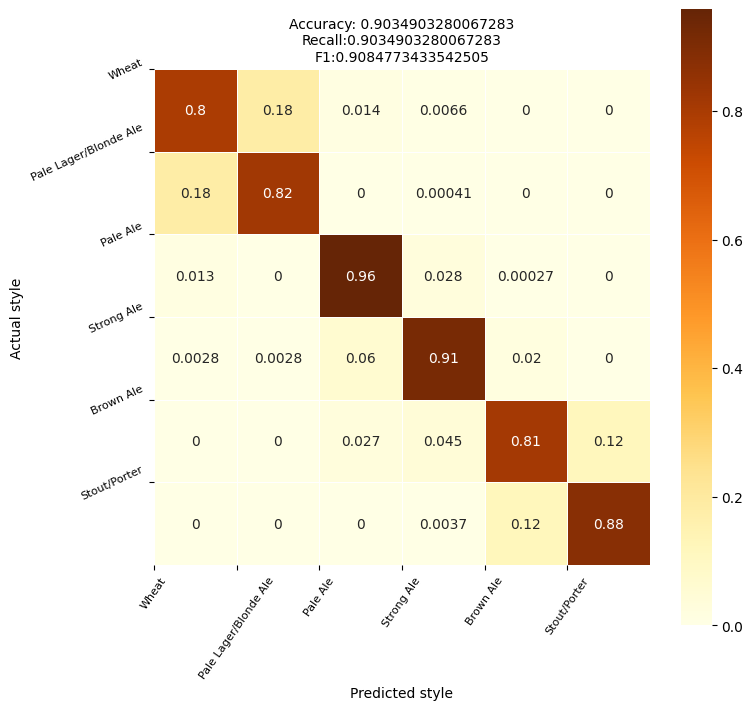

In [29]:
plt.figure(figsize=(8,8))
sns.heatmap(cmB, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_predB)}\nRecall:{recall_score(y_test, y_predB, average="weighted")}\nF1:{f1_score(y_test, y_predB, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

In [58]:
current_directory = os.getcwd()

with open(os.path.join(current_directory, '..', 'models', 'gbc_hypergs_config.yaml'), 'w') as file:
    yaml.dump(gbcB_gs.best_params_, file, default_flow_style=False)

with open('../models/trained_model_gbc_hypergs.pkl', 'wb') as output:
    pickle.dump(gbcB_gs.best_estimator_, output)

Although this model is pretty good, the first gradient boosting model [(05Entrenamiento_evaluacionGS.ipynb)](05Entrenamiento_evaluacionGS.ipynb) was the best one.